#1. Mount Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#2. OpenCV version Change

In [2]:
!pip uninstall opencv-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30


In [3]:
%cd  "/gdrive/My Drive/cv2_cuda"
!cp cv2.cpython-37m-x86_64-linux-gnu.so /usr/local/lib/python3.6/dist-packages

/gdrive/My Drive/cv2_cuda


#3. import the necessary packages & file read



In [4]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import IPython
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import pickle
import sys
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2203648/45929032 bytes (4.8%)5439488/45929032 bytes (11.8%)8642560/45929032 bytes (18.8%)11894784/45929032 bytes (25.9%)15122432/45929032 bytes (32.9%)18399232/45929032 bytes (40.1%)21716992/45929032 bytes (47.3%)24854528/45929032 bytes (54.1%)27951104/45929032 bytes (60.9%)30965760/45929032 bytes (67.4%)34480128/45929032 bytes (75.1%)37625856/45929032 bytes (81.9%)

In [5]:
!ls -al '/gdrive/My Drive/autonomous_data/black_box/video'

total 183655
-rw------- 1 root root 53488766 Sep 24 09:29 hightway_1.avi
-rw------- 1 root root 53226622 Sep 27 12:41 hightway_2.avi
-rw------- 1 root root 24769178 Sep 24 08:53 highway_road_2_down.mp4
-rw------- 1 root root 24088654 Sep 24 09:20 highway_road_3_down.mp4
-rw------- 1 root root 24831054 Sep 24 09:20 highway_road_4_down.mp4
-rw------- 1 root root  7655521 Oct  9 08:18 highway_road_6_down.mp4


In [6]:
# Write Video
def writeFrame(img):
    # use global variable, writer
    global writer
    height, width = img.shape[:2]
    if writer is None and output_name is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
    if writer is not None:
        writer.write(img)

In [7]:
import numpy as np
import cv2
class tracker():
	
	def __init__(self, Mywindow_width, Mywindow_height, Mymargin, My_ym = 1, My_xm = 1, Mysmooth_factor = 15):
		#list that stores all the past (left,right,center) set values used for smoothing the output
		self.recent_centers = []
		
		# The window pixel width of the center values, used to count pixels inside center windows to determine curve values
		self.window_width = Mywindow_width
		
		# The window pixel height of the center values, used to count pixels inside center windows to determine curve values
		# breaks the image into vertical levels
		self.window_height = Mywindow_height
		
		# The pixel distance in both directions to slide (left_window + right_window) template for searching
		self.margin = Mymargin
		
		self.ym_per_pix = My_ym # meters per pixel in vertical axis
		
		self.xm_per_pix = My_xm # meters per pixel in horizontal axis
		
		self.smooth_factor = Mysmooth_factor
		
	# Main tracking function for finding & storing the lane segment positions
	def find_window_centroids(self, warped):
		
			window_width = self.window_width
			window_height = self.window_height
			margin = self.margin
			
			window_centroids = [] # store the (left,right) window centroid positions per level
			window = np.ones(window_width) # create our window template that we will use for convolutions
			
			# first find the two starting positions for the left & right lane by using np.sum to get the vertical image slice
			# and then np.convolve the vertical image slice with the window template
			
			#sum quarter bottom of image to get slice, could use a different ratio
			l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
			l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
			r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
			r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
			
			# Add what we found for the 1st layer
			window_centroids.append((l_center,r_center))
			
			# Go thru each layer looking for max pixel locations
			for level in range(1,(int)(warped.shape[0]/window_height)):
				# convolve the window into the vertical slice of the image
				image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
				conv_signal = np.convolve(window, image_layer)
				# Find the best left centroid by using past left center as a reference
				# Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
				offset = window_width/2
				l_min_index = int(max(l_center+offset-margin,0))
				l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
				l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
				# Find the best right centroid by using past right center as a reference
				r_min_index = int(max(r_center+offset-margin,0))
				r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
				r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
				# Add what we found for that layer
				window_centroids.append((l_center,r_center))

			self.recent_centers.append(window_centroids)
			# return averaged values of the line centers, helps to keep the markers from sliding too much
			return np.average(self.recent_centers[-self.smooth_factor:], axis=0)

In [8]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.

def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary) == 1] = 1

    # Return the combined s_channel & v_channel binary image
    return output

def s_channel_threshold(image, sthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]  # use S channel

    # create a copy and apply the threshold
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    return binary_output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    return output

In [9]:
frame_count = 0
# initialize the video writer 
writer = None
output_name = 'advanced_lanedetection.avi'

In [10]:
weight_file = '/gdrive/My Drive/darknet/weights/yolov4.weights'
cfg_file = '/gdrive/My Drive/darknet/cfg/yolov4.cfg'
name_file = '/gdrive/My Drive/darknet/data/coco.names'

min_confidence = 0.4
#net = cv2.dnn.readNet(weight_file, cfg_file)
# Load Yolo
net = cv2.dnn.readNetFromDarknet(cfg_file, weight_file)

classes = []
with open(name_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)
layer_names = net.getLayerNames()
print(layer_names)

uncconted = []
for i in net.getUnconnectedOutLayers():
    uncconted.append([i])

output_layers = [layer_names[un[0] - 1] for un in uncconted]

red = (0,0,255)
green = (0,255,0)
blue = (255,0,0)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
('conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5

In [ ]:
def detectAndDisplay_binaryimg(frame):
    IPython.display.clear_output(wait=True)

    #pass image thru the pipeline
    preprocessImage = np.zeros_like(frame[:,:,0])
    gradx = abs_sobel_thresh(frame, orient='x', thresh_min=5, thresh_max=255)
    grady = abs_sobel_thresh(frame, orient='y', thresh_min=5, thresh_max=255)
    c_binary = color_threshold(frame, sthresh=(0,255), vthresh=(95,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
    preprocessImage2 = np.zeros_like(frame)
    preprocessImage2[:,:,0] = preprocessImage
    preprocessImage2[:,:,1] = preprocessImage
    preprocessImage2[:,:,2] = preprocessImage
    cv2_imshow(preprocessImage2)
    writeFrame(preprocessImage2)

In [ ]:
def detectAndDisplay_polygon(frame):
    IPython.display.clear_output(wait=True)
    gidx = 0

    #pass image thru the pipeline
    preprocessImage = np.zeros_like(frame[:,:,0])
    gradx = abs_sobel_thresh(frame, orient='x', thresh_min=5, thresh_max=255)
    grady = abs_sobel_thresh(frame, orient='y', thresh_min=5, thresh_max=255)
    c_binary = color_threshold(frame, sthresh=(0,255), vthresh=(95,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    frame_size = (frame.shape[1], frame.shape[0])

    height, width = frame.shape[:2]
    poly_heigh = int(0.715 * height)
    poly_left = int(0.500 * width)
    poly_right = int(0.550 * width)
    poly_bottom = int(0.95 * height)
    poly_right_bottom = int(0.85 * width)
    poly_left_bottom = int(0.32 * width)
    src = np.array([[(poly_left, poly_heigh),(poly_right, poly_heigh),(poly_right_bottom, poly_bottom),(poly_left_bottom, poly_bottom)]])
    
    image = cv2.polylines(frame, [src], True, (0,0,255), 2)
    cv2_imshow(image)
    writeFrame(image)

In [ ]:
def detectAndDisplay_wraped(frame):
    IPython.display.clear_output(wait=True)
    gidx = 0

    #pass image thru the pipeline
    preprocessImage = np.zeros_like(frame[:,:,0])
    gradx = abs_sobel_thresh(frame, orient='x', thresh_min=5, thresh_max=255)
    grady = abs_sobel_thresh(frame, orient='y', thresh_min=5, thresh_max=255)
    c_binary = color_threshold(frame, sthresh=(0,255), vthresh=(95,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    frame_size = (frame.shape[1], frame.shape[0])

    height, width = frame.shape[:2]
    poly_heigh = int(0.715 * height)
    poly_left = int(0.500 * width)
    poly_right = int(0.550 * width)
    poly_bottom = int(0.95 * height)
    poly_right_bottom = int(0.85 * width)
    poly_left_bottom = int(0.32 * width)
    src = np.float32([[(poly_left, poly_heigh),(poly_right, poly_heigh),(poly_right_bottom, poly_bottom),(poly_left_bottom, poly_bottom)]])
    offset = height * 0.25
    dst = np.float32([[offset,0],[frame_size[0]-offset,0],[frame_size[0]-offset,frame_size[1]],[offset,frame_size[1]]])

    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,frame_size,flags=cv2.INTER_LINEAR)

    warped2 = np.zeros_like(frame)
    warped2[:,:,0] = warped
    warped2[:,:,1] = warped
    warped2[:,:,2] = warped

    dst1 = (int(dst[0][0]), int(dst[0][1]))
    dst2 = (int(dst[2][0]), int(dst[2][1]))

    warped2 = cv2.rectangle(warped2, dst1, dst2,(0,0,255), 2)
    cv2_imshow(warped2)
    writeFrame(warped2)

In [ ]:
def detectAndDisplay_lane(frame):
    IPython.display.clear_output(wait=True)
    gidx = 0

    #pass image thru the pipeline
    preprocessImage = np.zeros_like(frame[:,:,0])
    gradx = abs_sobel_thresh(frame, orient='x', thresh_min=5, thresh_max=255)
    grady = abs_sobel_thresh(frame, orient='y', thresh_min=5, thresh_max=255)
    c_binary = color_threshold(frame, sthresh=(0,255), vthresh=(95,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    frame_size = (frame.shape[1], frame.shape[0])

    height, width = frame.shape[:2]
    poly_heigh = int(0.715 * height)
    poly_left = int(0.500 * width)
    poly_right = int(0.550 * width)
    poly_bottom = int(0.95 * height)
    poly_right_bottom = int(0.85 * width)
    poly_left_bottom = int(0.32 * width)
    src = np.float32([[(poly_left, poly_heigh),(poly_right, poly_heigh),(poly_right_bottom, poly_bottom),(poly_left_bottom, poly_bottom)]])
    offset = height * 0.25
    dst = np.float32([[offset,0],[frame_size[0]-offset,0],[frame_size[0]-offset,frame_size[1]],[offset,frame_size[1]]])

    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,frame_size,flags=cv2.INTER_LINEAR)

    window_width = 50
    window_height = 80
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

    cv2_imshow(result)
    writeFrame(result)

In [ ]:
def detectAndDisplay_road(frame):
    IPython.display.clear_output(wait=True)
    gidx = 0

    #pass image thru the pipeline
    preprocessImage = np.zeros_like(frame[:,:,0])
    gradx = abs_sobel_thresh(frame, orient='x', thresh_min=5, thresh_max=255)
    grady = abs_sobel_thresh(frame, orient='y', thresh_min=5, thresh_max=255)
    c_binary = color_threshold(frame, sthresh=(0,255), vthresh=(95,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    frame_size = (frame.shape[1], frame.shape[0])

    height, width = frame.shape[:2]
    poly_heigh = int(0.715 * height)
    poly_left = int(0.500 * width)
    poly_right = int(0.550 * width)
    poly_bottom = int(0.95 * height)
    poly_right_bottom = int(0.85 * width)
    poly_left_bottom = int(0.32 * width)
    src = np.float32([[(poly_left, poly_heigh),(poly_right, poly_heigh),(poly_right_bottom, poly_bottom),(poly_left_bottom, poly_bottom)]])
    offset = height * 0.25
    dst = np.float32([[offset,0],[frame_size[0]-offset,0],[frame_size[0]-offset,frame_size[1]],[offset,frame_size[1]]])

    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,frame_size,flags=cv2.INTER_LINEAR)

    window_width = 50
    window_height = 80
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])

    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    #res_yvals = np.delete(res_yvals, -1)

    leftx = np.array(leftx)
    rightx = np.array(rightx)


    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)

    right_fit = np.polyfit(res_yvals-1, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(frame)
    road_bkg = np.zeros_like(frame)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road,[inner_lane],color=[0,255,0])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_warped = cv2.warpPerspective(road,Minv,frame_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,frame_size,flags=cv2.INTER_LINEAR)

    base = cv2.addWeighted(frame,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)

    cv2_imshow(road)
    writeFrame(road)

In [ ]:
def detectAndDisplay_seg(frame):
    IPython.display.clear_output(wait=True)
    gidx = 0

    #pass image thru the pipeline
    preprocessImage = np.zeros_like(frame[:,:,0])
    gradx = abs_sobel_thresh(frame, orient='x', thresh_min=5, thresh_max=255)
    grady = abs_sobel_thresh(frame, orient='y', thresh_min=5, thresh_max=255)
    c_binary = color_threshold(frame, sthresh=(0,255), vthresh=(95,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    frame_size = (frame.shape[1], frame.shape[0])

    height, width = frame.shape[:2]
    poly_heigh = int(0.715 * height)
    poly_left = int(0.500 * width)
    poly_right = int(0.550 * width)
    poly_bottom = int(0.95 * height)
    poly_right_bottom = int(0.85 * width)
    poly_left_bottom = int(0.32 * width)
    src = np.float32([[(poly_left, poly_heigh),(poly_right, poly_heigh),(poly_right_bottom, poly_bottom),(poly_left_bottom, poly_bottom)]])
    offset = height * 0.25
    dst = np.float32([[offset,0],[frame_size[0]-offset,0],[frame_size[0]-offset,frame_size[1]],[offset,frame_size[1]]])

    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,frame_size,flags=cv2.INTER_LINEAR)

    window_width = 50
    window_height = 80
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])

    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    #res_yvals = np.delete(res_yvals, -1)

    leftx = np.array(leftx)
    rightx = np.array(rightx)


    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)

    right_fit = np.polyfit(res_yvals-1, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(frame)
    road_bkg = np.zeros_like(frame)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road,[inner_lane],color=[0,255,0])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_warped = cv2.warpPerspective(road,Minv,frame_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,frame_size,flags=cv2.INTER_LINEAR)

    base = cv2.addWeighted(frame,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)

    cv2_imshow(result)
    writeFrame(result)

In [12]:
def detectAndDisplay_fianl(frame):
    IPython.display.clear_output(wait=True)

    #pass image thru the pipeline
    preprocessImage = np.zeros_like(frame[:,:,0])
    gradx = abs_sobel_thresh(frame, orient='x', thresh_min=5, thresh_max=255)
    grady = abs_sobel_thresh(frame, orient='y', thresh_min=5, thresh_max=255)
    c_binary = color_threshold(frame, sthresh=(100,255), vthresh=(95,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    frame_size = (frame.shape[1], frame.shape[0])

    height, width = frame.shape[:2]
    mask = np.zeros((height,width), dtype='uint8')
    poly_heigh = int(0.715 * height)
    poly_left = int(0.495 * width)
    poly_right = int(0.545 * width)
    poly_bottom = int(0.95 * height)
    poly_right_bottom = int(0.85 * width)
    poly_left_bottom = int(0.32 * width)
    src = np.float32([(poly_left, poly_heigh),(poly_right, poly_heigh),(poly_right_bottom, poly_bottom),(poly_left_bottom, poly_bottom)])
    offset = height * 0.25
    dst = np.float32([[offset,0],[frame_size[0]-offset,0],[frame_size[0]-offset,frame_size[1]],[offset,frame_size[1]]])

    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,frame_size,flags=cv2.INTER_LINEAR)

    window_width = 50
    window_height = 80

    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)

    window_centroids = curve_centers.find_window_centroids(warped)

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])

    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    #res_yvals = np.delete(res_yvals, -1)

    leftx = np.array(leftx)
    rightx = np.array(rightx)


    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)

    right_fit = np.polyfit(res_yvals-1, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(frame)
    road_bkg = np.zeros_like(frame)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_warped = cv2.warpPerspective(road,Minv,frame_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,frame_size,flags=cv2.INTER_LINEAR)

    base = cv2.addWeighted(frame,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)

    ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix # meters per pixel in x dimension

    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])

    # Calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []
    class_kinds = {}

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > min_confidence:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
    font = cv2.FONT_HERSHEY_COMPLEX
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            
            if label == 'car':
                cv2.rectangle(result, (x, y), (x + w, y + h), blue, 2)
                cv2.rectangle(result, (x - 2, y - 1), (x + len(label) * 16 + 15, y - 25), blue, -1)
                cv2.putText(result, label, (x, y - 8), font, 1, (255, 255, 255), 2)
            elif label == 'truck':
                cv2.rectangle(result, (x, y), (x + w, y + h), green, 2)
                cv2.rectangle(result, (x - 2, y - 1), (x + len(label) * 16 + 15, y - 25), green, -1)
                cv2.putText(result, label, (x, y - 8), font, 1, (255, 255, 255), 2)
            else:
                cv2.rectangle(result, (x, y), (x + w, y + h), red, 2)
                cv2.rectangle(result, (x - 2, y - 1), (x + len(label) * 16 + 15, y - 25), red, -1)
                cv2.putText(result, label, (x, y - 8), font, 1, (255, 255, 255), 2)

            if classes[class_ids[i]] in class_kinds:
                    class_kinds[classes[class_ids[i]]] = class_kinds[classes[class_ids[i]]] + 1
            else:
                    class_kinds[classes[class_ids[i]]] = 1
                    
    # draw the text showing curvature, offset & speed
    cv2.putText(result, 'Radius of Curvature=',(50,100),cv2.FONT_HERSHEY_DUPLEX, 2 ,(255,255,255),8)
    cv2.putText(result, str(round(curverad,3))+'m',(750,100),cv2.FONT_HERSHEY_DUPLEX, 2 ,(125, 125, 125),8)
    cv2.putText(result, 'Vehicle is ',(50,160), cv2.FONT_HERSHEY_DUPLEX, 2 ,(255,255,255),8)
    if side_pos == 'right':
        cv2.putText(result, str(abs(round(center_diff,3)))+'m '+str(side_pos),(400,160), cv2.FONT_HERSHEY_DUPLEX, 2 ,red ,8)
    else:
        cv2.putText(result, str(abs(round(center_diff,3)))+'m '+str(side_pos),(400,160), cv2.FONT_HERSHEY_DUPLEX, 2 ,blue ,8)
    cv2.putText(result, ' of center',(820,160), cv2.FONT_HERSHEY_DUPLEX, 2 ,(255,255,255),8)

    index = 220
    for key, value in class_kinds.items():
        cv2.putText(result, key +' : ' + str(value),(50,index),cv2.FONT_HERSHEY_DUPLEX, 2 ,(255,255,255),8)
        index += 60
        
    cv2_imshow(result)
    writeFrame(result)

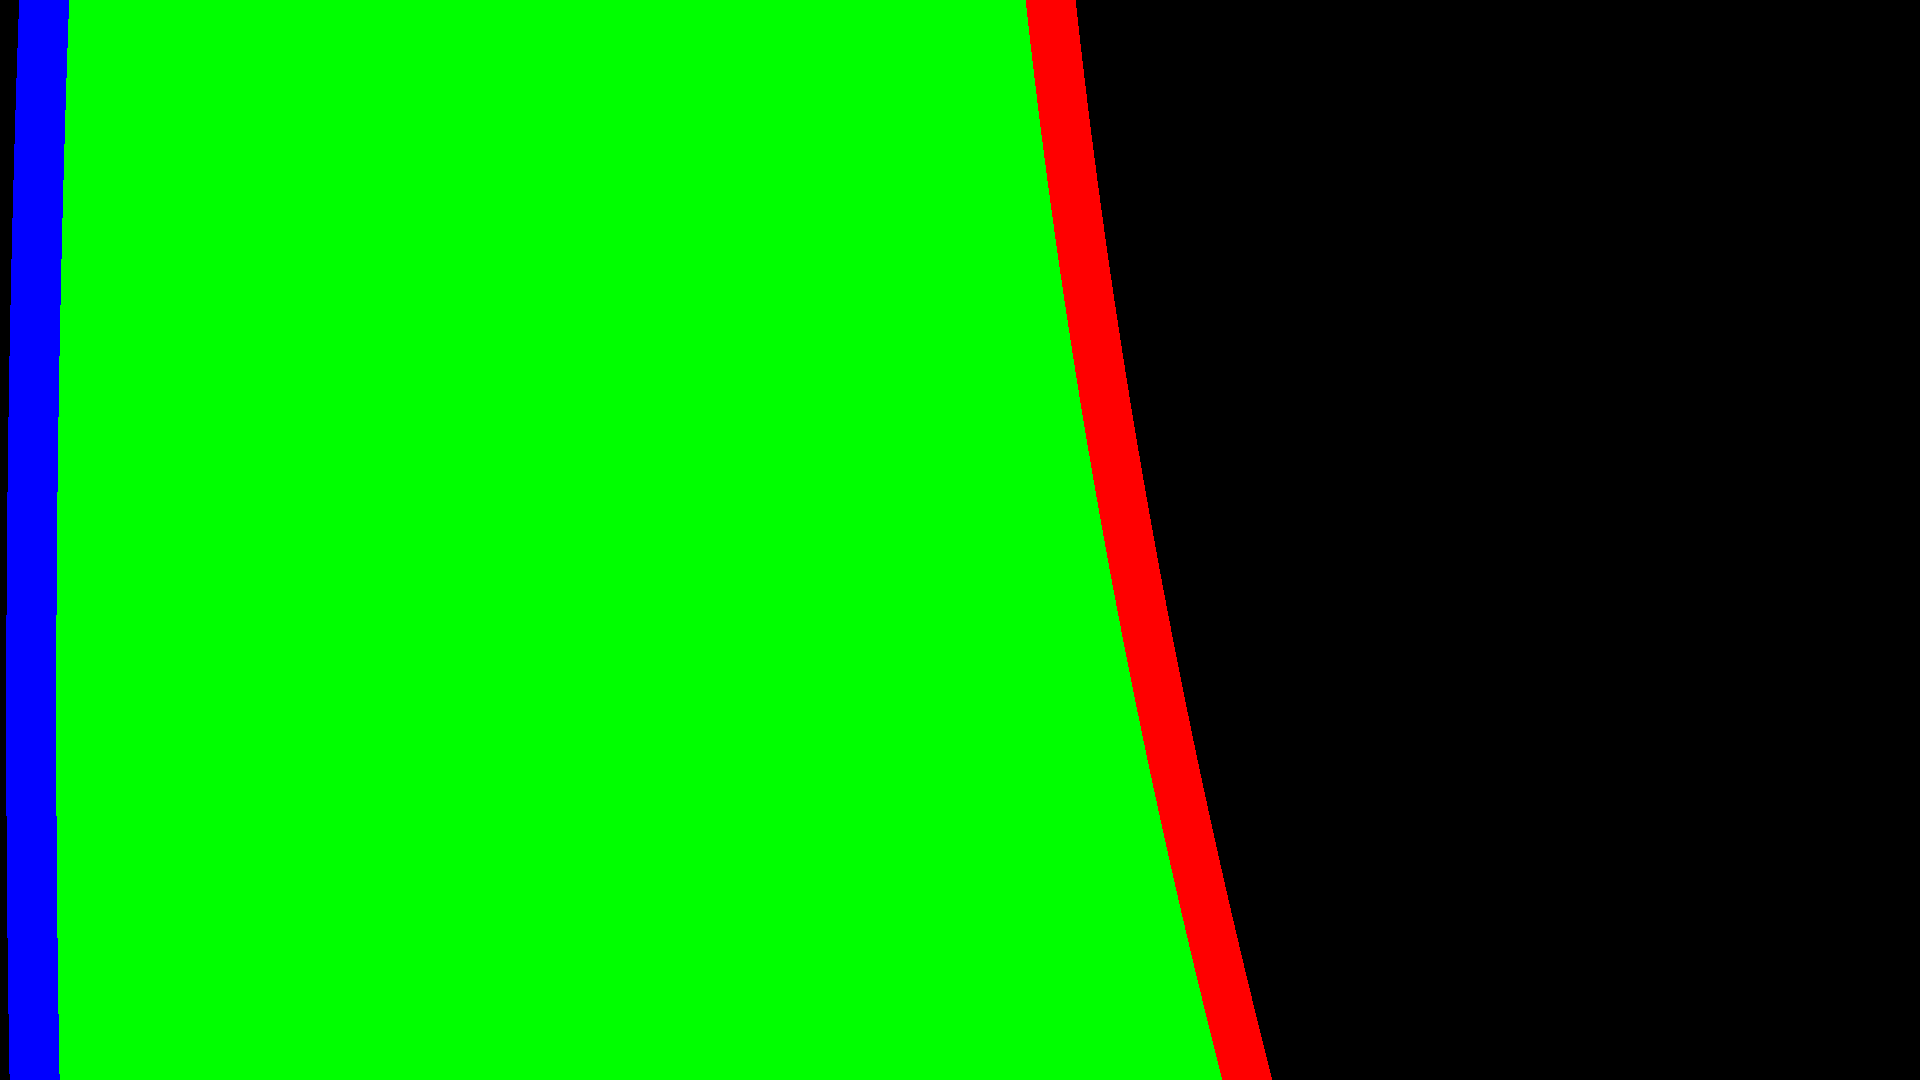

--(!) No captured frame -- Break!


In [ ]:
file_name = '/gdrive/My Drive/autonomous_data/black_box/video/highway_road_6_down.mp4'

#-- 2. Read the video stream
for i in range(6):
    cap = cv2.VideoCapture(file_name)
    if not cap.isOpened:
        print('--(!)Error opening video capture')
        exit(0)
    while True:
        ret, frame = cap.read()
        if frame is None:
            print('--(!) No captured frame -- Break!')
            break
        if i == 0:
            detectAndDisplay_binaryimg(frame)
        elif i == 1:
            detectAndDisplay_polygon(frame)
        elif i == 2:
            detectAndDisplay_wraped(frame)
        elif i == 3:
            detectAndDisplay_lane(frame)
        elif i == 4:
            detectAndDisplay_seg(frame)
        elif i == 5:
            detectAndDisplay_road(frame)
        
        #detectAndDisplay_fianl(frame)

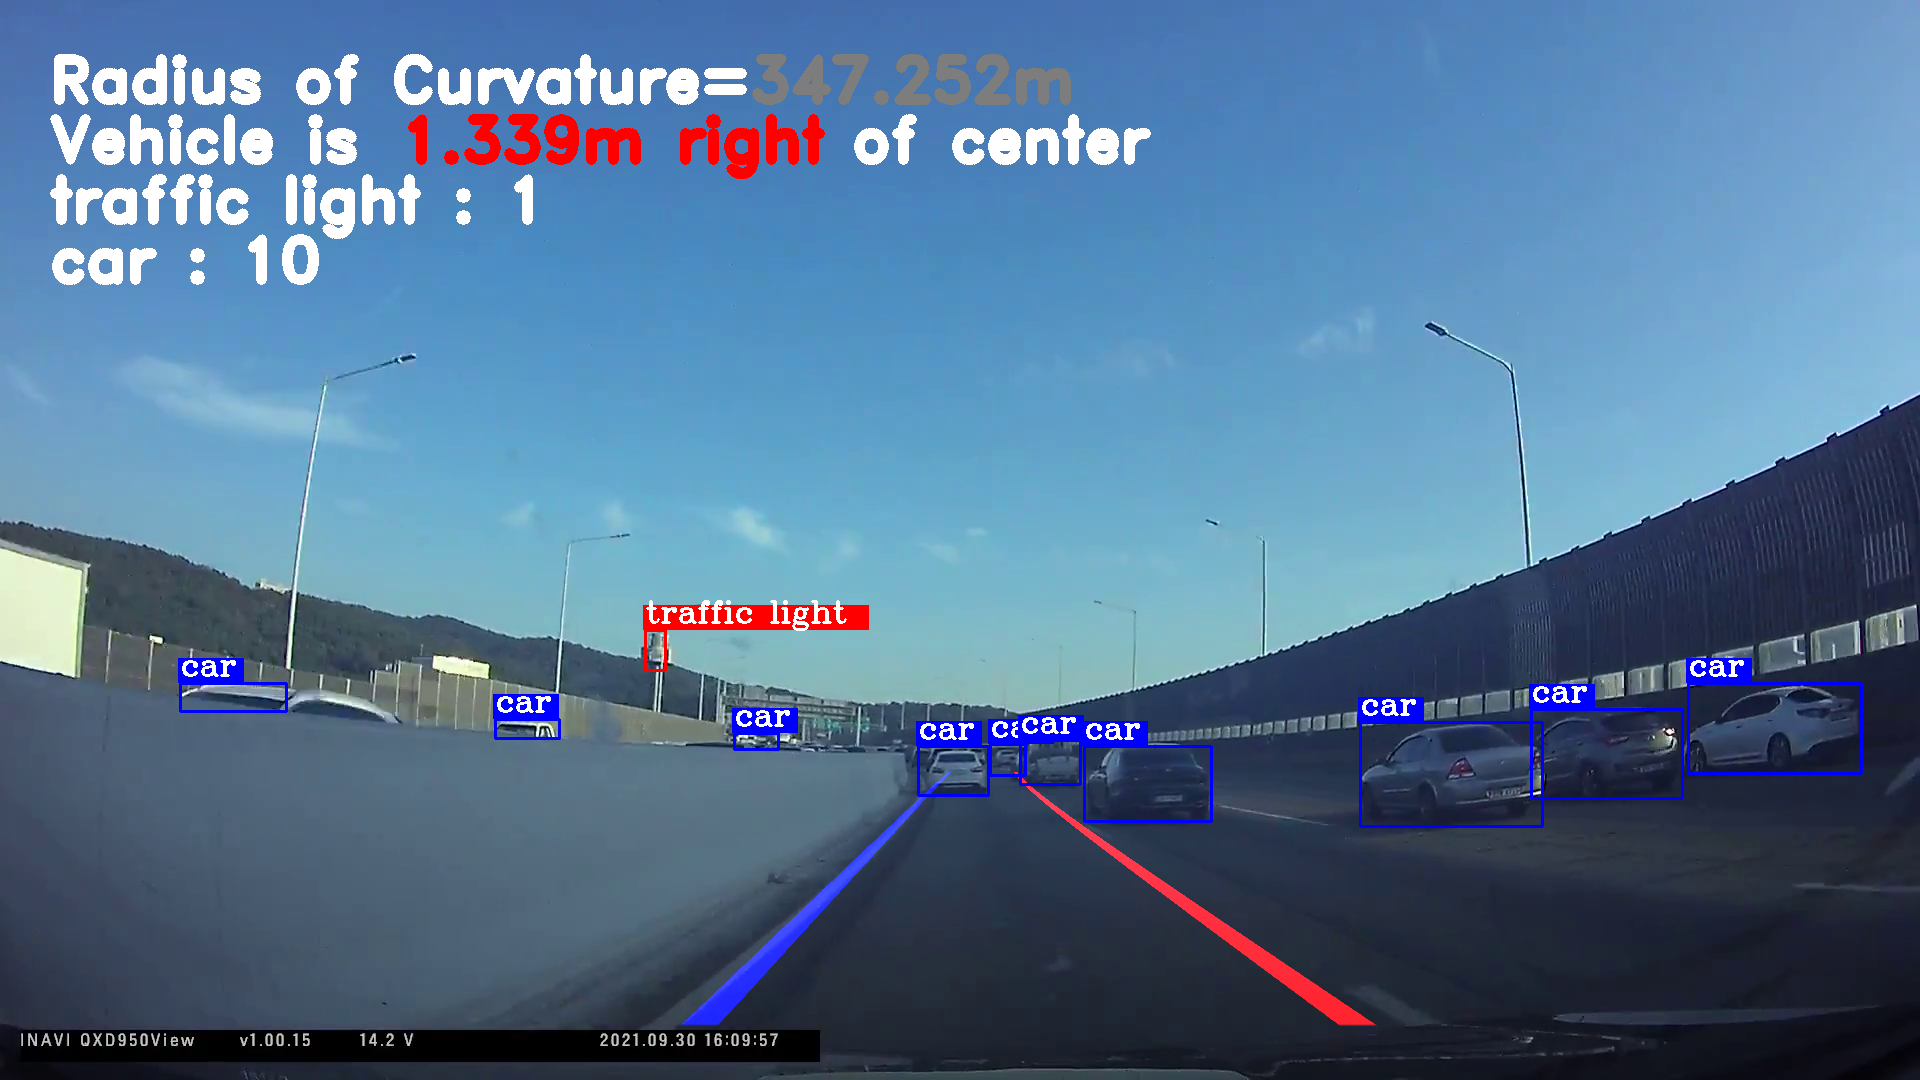

--(!) No captured frame -- Break!


In [13]:
file_name = '/gdrive/My Drive/autonomous_data/black_box/video/highway_road_6_down.mp4'

#-- 2. Read the video stream
cap = cv2.VideoCapture(file_name)
if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)
while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break
    detectAndDisplay_fianl(frame)

In [14]:
from google.colab import files
files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>